In [7]:

import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
tf.random.set_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

Let's start by print out the versions of the libraries we're using for future reference

# Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [14]:
dataset = pd.read_csv('../input/datagdp/GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

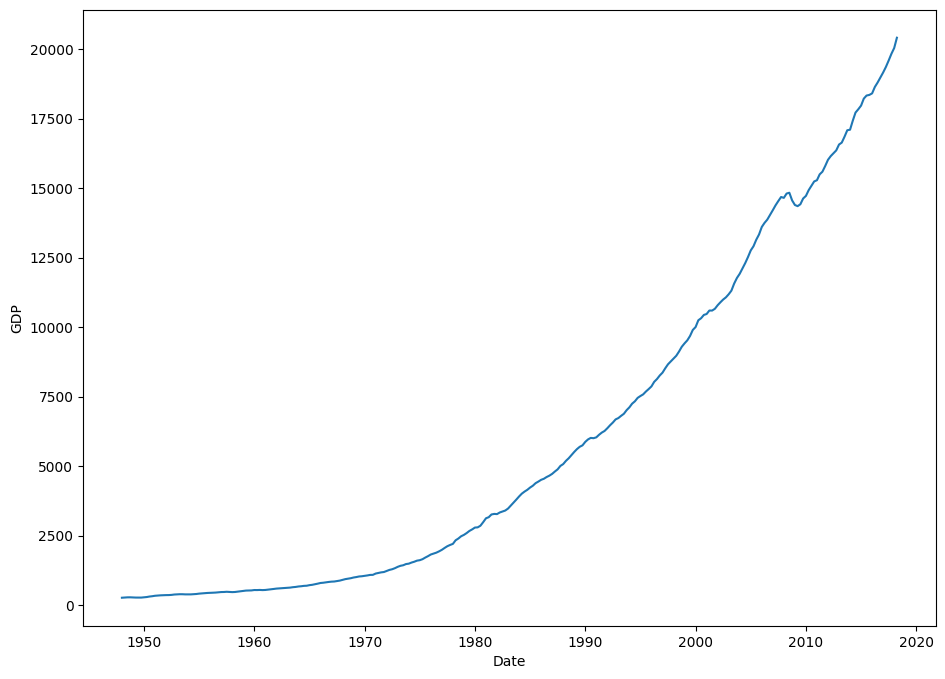

In [15]:
plt.plot(dataset['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP');
plt.gcf().set_size_inches(11,8)

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [18]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1, 1)
dataset.iloc[1:, dataset.columns.get_loc('diff')] = series

A quick plot...

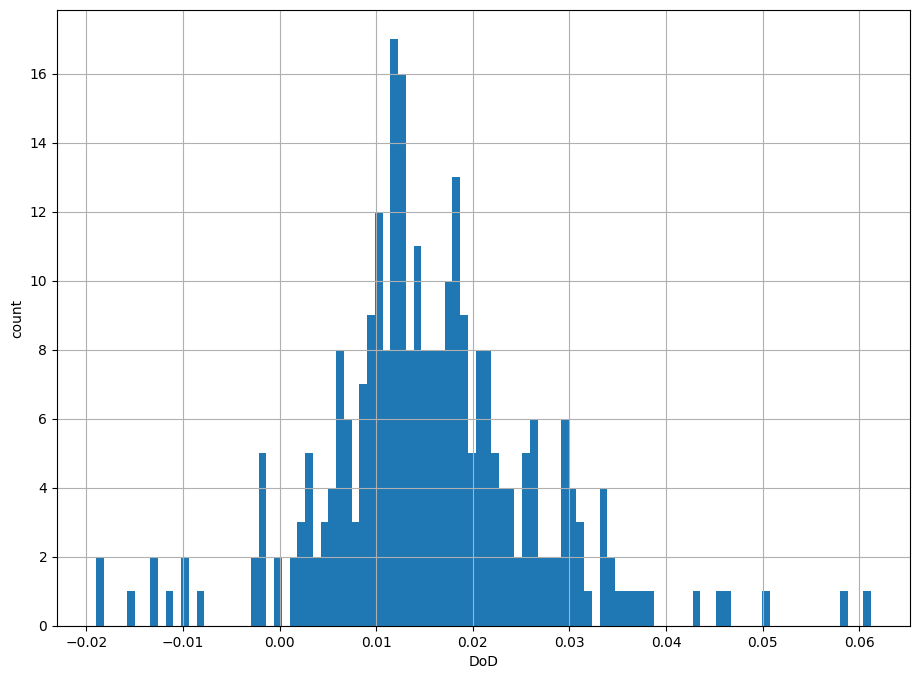

In [19]:
dataset['diff'].hist(bins=100)
plt.xlabel('DoD')
plt.ylabel('count')
plt.gcf().set_size_inches(11, 8)

## Training and Testing datasets 
The y values are just the next x value

In [22]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [23]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 188 training points and 92 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [25]:
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(188, 1, 1)
(92, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [26]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [27]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
12/12 [==============================] - 1s 2ms/step - loss: 0.0793
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0739
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0732
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0725
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0727
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0724
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 13/100
12/12 [=================

## Make predictions

In [28]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


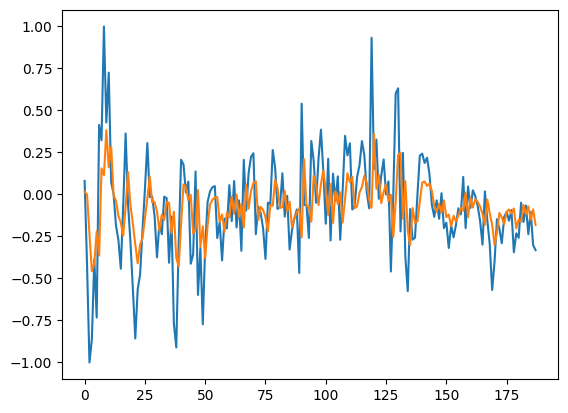

In [29]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [38]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.iloc[1:train_points+1, dataset.columns.get_loc('RNN_train_predict')] = 1+scaler.inverse_transform(y_train_pred)
dataset.iloc[train_points+2:, dataset.columns.get_loc('RNN_test_predict')] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

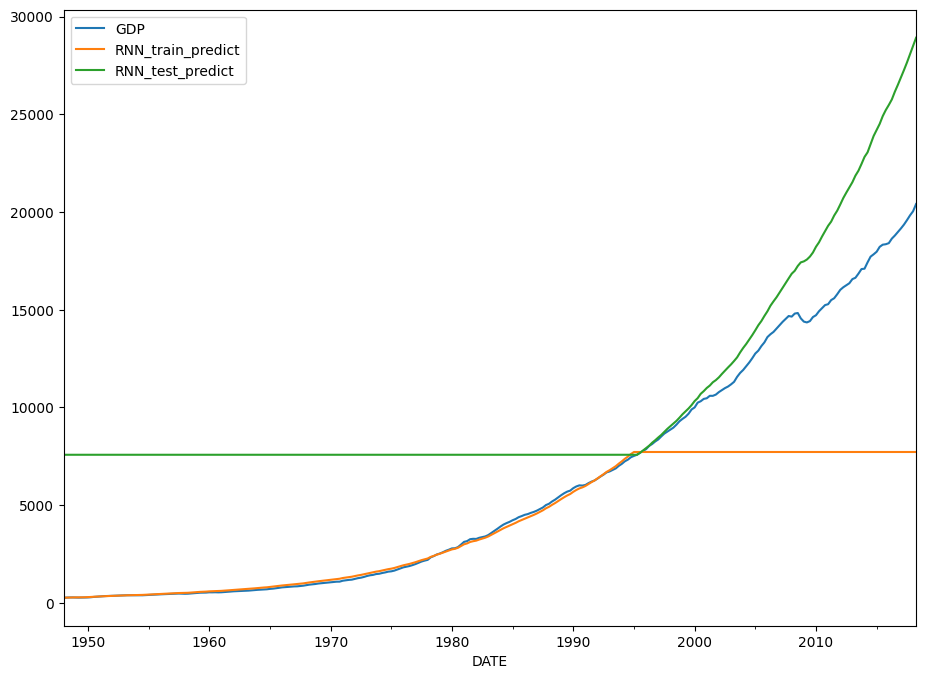

In [39]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# LSTM
Let's now try using a slightly more sophisticated architecture

In [40]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [42]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
6/6 [==============================] - 2s 3ms/step - loss: 0.0879
Epoch 2/500
6/6 [==============================] - 0s 4ms/step - loss: 0.0862
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0850
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0829
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0822
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0814
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 9/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0807
Epoch 10/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0803
Epoch 11/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0799
Epoch 12/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0796
Epoch 13/500
6/6 [==============================] - 0s 3ms/st

Calculate the predicted values

In [44]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.iloc[1:train_points+1, dataset.columns.get_loc('LSTM_train_predict')] = 1+scaler.inverse_transform(y_train_pred)
dataset.iloc[train_points+2:, dataset.columns.get_loc('LSTM_test_predict')] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

3/3 [==============================] - 0s 3ms/step


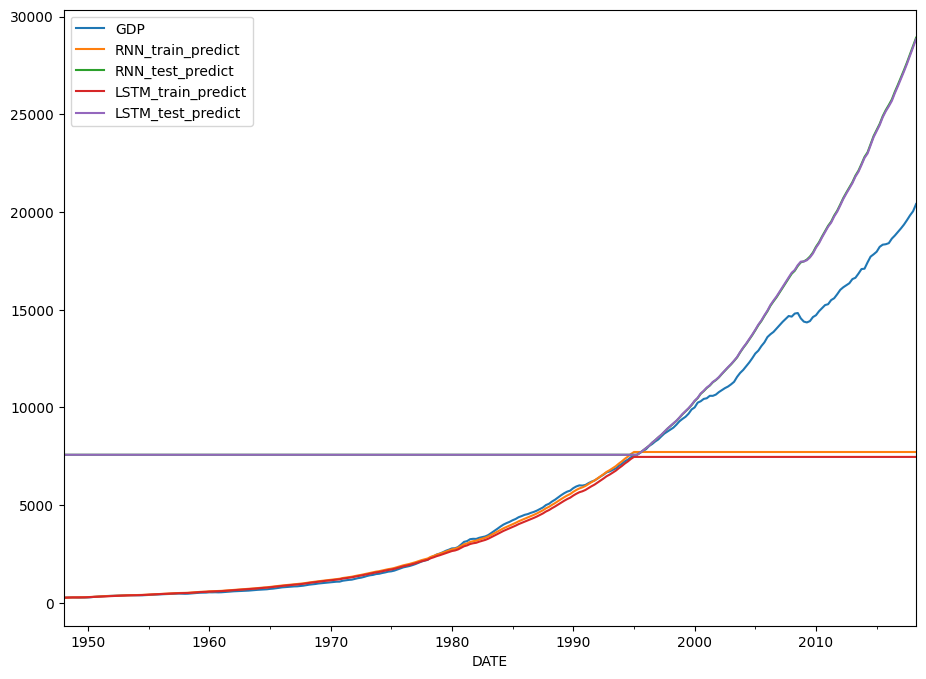

In [45]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 'LSTM_train_predict', 'LSTM_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [47]:
X2 = np.concatenate([X[0:-4], X[1:-3], X[2:-2], X[3:-1]], axis=1)
y2 = X[4:]

X2_train, X2_test = X2[:train_points], X2[train_points:]
y2_train, y2_test = y2[:train_points], y2[train_points:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 188 training points and 88 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [49]:
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(188, 4, 1)
(88, 4, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [50]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [51]:
nb_epoch = 500
model.fit(X2_train, y2_train, epochs=nb_epoch, batch_size=12)

Epoch 1/500
16/16 [==============================] - 2s 4ms/step - loss: 0.0775
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0747
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0740
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0739
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0730
Epoch 8/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0722
Epoch 10/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 11/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 12/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 13/500
16/16 [=================

In [52]:
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

dataset['LSTM3_train_predict'] = 1
dataset['LSTM3_test_predict'] = 1
dataset.iloc[4:train_points+4, dataset.columns.get_loc('LSTM3_train_predict')] = 1+scaler.inverse_transform(y_train_pred)
dataset.iloc[train_points+6:, dataset.columns.get_loc('LSTM3_test_predict')] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM3_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM3_train_predict'].cumprod()
dataset['LSTM3_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM3_test_predict'].cumprod()

3/3 [==============================] - 0s 3ms/step


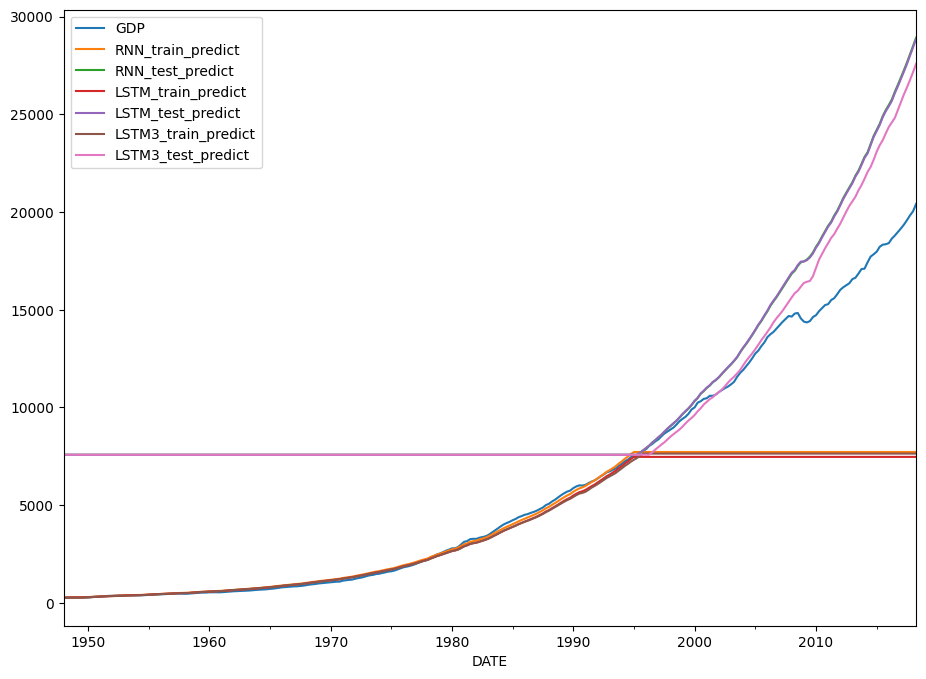

In [53]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 
                'LSTM_train_predict', 'LSTM_test_predict', 
                'LSTM3_train_predict', 'LSTM3_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)